<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Keypoint_Detection_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U imgaug


     |████████████████████████████████| 952kB 8.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.


In [ ]:
!wget -q http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar


In [ ]:
!tar xf images.tar
!unzip -qq ~/stanfordextra_v12.zip

unzip:  cannot find or open /root/stanfordextra_v12.zip, /root/stanfordextra_v12.zip.zip or /root/stanfordextra_v12.zip.ZIP.


In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5
NUM_KEYPOINTS = 24 * 2  # 24 pairs each having x and y coordinates

In [ ]:
!python -m pip install "git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI"

  Cloning https://github.com/philferriere/cocoapi.git to /tmp/pip-req-build-na18biz_
  Running command git clone -q https://github.com/philferriere/cocoapi.git /tmp/pip-req-build-na18biz_
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264105 sha256=2c9d301391505eaf4541030b7240c4cb544fbf53f744da9368cf1f731ec4458c
  Stored in directory: /tmp/pip-ephem-wheel-cache-q7_o_ub4/wheels/69/2b/12/2fa959e49f73d26cff202c2f4e5079096c9c57c8a8509fd75c
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [ ]:
IMG_DIR = "Images"
JSON = "/content/StanfordExtra_sample.json"
KEYPOINT_DEF = (
    "https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv"
)

with open(JSON) as infile:
  json_data = json.load(infile)

# Set up a dictionary, mapping all the ground-truth information
# with respect to the path of the image.
json_dict = {i['img_path']: i for i in json_data}


In [ ]:
json_dict

{'n02087394-Rhodesian_ridgeback/n02087394_10591.jpg': {'img_bbox': [7,
   13,
   349,
   279],
  'img_height': 296,
  'img_path': 'n02087394-Rhodesian_ridgeback/n02087394_10591.jpg',
  'img_width': 360,
  'is_multiple_dogs': False,
  'joints': [[258.5, 277.0, 1.0],
   [252.33333333333334, 235.0, 1.0],
   [282.0, 172.33333333333334, 1.0],
   [100.0, 258.0, 1.0],
   [97.66666666666667, 214.66666666666666, 1.0],
   [119.66666666666667, 152.66666666666666, 1.0],
   [283.5, 285.0, 1.0],
   [271.5, 260.5, 1.0],
   [265.0, 176.66666666666666, 1.0],
   [75.33333333333333, 273.6666666666667, 1.0],
   [69.0, 228.5, 1.0],
   [97.66666666666667, 136.33333333333334, 1.0],
   [93.66666666666667, 83.66666666666667, 1.0],
   [11.666666666666666, 86.33333333333333, 1.0],
   [329.0, 24.333333333333332, 1.0],
   [289.3333333333333, 21.333333333333332, 1.0],
   [301.3333333333333, 50.666666666666664, 1.0],
   [308.3333333333333, 66.33333333333333, 1.0],
   [338.88139730639733, 58.82925084175084, 1.0],
   

In [ ]:
json_dict.keys()

dict_keys(['n02087394-Rhodesian_ridgeback/n02087394_10591.jpg', 'n02087394-Rhodesian_ridgeback/n02087394_1352.jpg', 'n02087394-Rhodesian_ridgeback/n02087394_36.jpg', 'n02087394-Rhodesian_ridgeback/n02087394_681.jpg', 'n02087394-Rhodesian_ridgeback/n02087394_831.jpg', 'n02087394-Rhodesian_ridgeback/n02087394_8339.jpg', 'n02092339-Weimaraner/n02092339_1013.jpg', 'n02092339-Weimaraner/n02092339_6077.jpg', 'n02092339-Weimaraner/n02092339_6410.jpg', 'n02092339-Weimaraner/n02092339_6543.jpg', 'n02092339-Weimaraner/n02092339_6548.jpg', 'n02092339-Weimaraner/n02092339_748.jpg', 'n02093754-Border_terrier/n02093754_1148.jpg', 'n02093754-Border_terrier/n02093754_1845.jpg', 'n02093754-Border_terrier/n02093754_3113.jpg', 'n02093754-Border_terrier/n02093754_3176.jpg', 'n02093754-Border_terrier/n02093754_6483.jpg', 'n02093754-Border_terrier/n02093754_875.jpg', 'n02099601-golden_retriever/n02099601_176.jpg', 'n02099601-golden_retriever/n02099601_2440.jpg', 'n02099601-golden_retriever/n02099601_2495.jp

In [ ]:
# Load the metdata definition file and preview it.
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

,Index,Name,Hex colour,Stanford,Animal-pose,(name in animal pose)
0,0,Left front leg: paw,d82400,y,y,L_F_Paw
1,1,Left front leg: middle joint,d82400,y,y,L_F_Knee
2,2,Left front leg: top,d82400,y,y,L_F_Elbow
3,3,Left rear leg: paw,fcfc00,y,y,L_B_Paw
4,4,Left rear leg: middle joint,fcfc00,y,y,L_B_Knee


In [ ]:
# Extract the colours and labels.
colours = keypoint_def['Hex colour'].values.tolist()
colours = ['#' + colour for colour in colours]
labels = keypoint_def['Name'].values.tolist()

# Utility for reading an image and for getting its annotations.
def get_dog(name):
  data = json_dict[name]
  img_data = plt.imread(os.path.join(IMG_DIR, data['img_path']))
  # If the image is RGBA convert it to RGB.
  if img_data.shape[-1] == 4:
    img_data = img_data.astype(np.uint8)
    img_data = Image.fromarray(img_data)
    img_data = np.array(img_data.convert('RGB'))
  data['img_data'] = img_data 

  return data

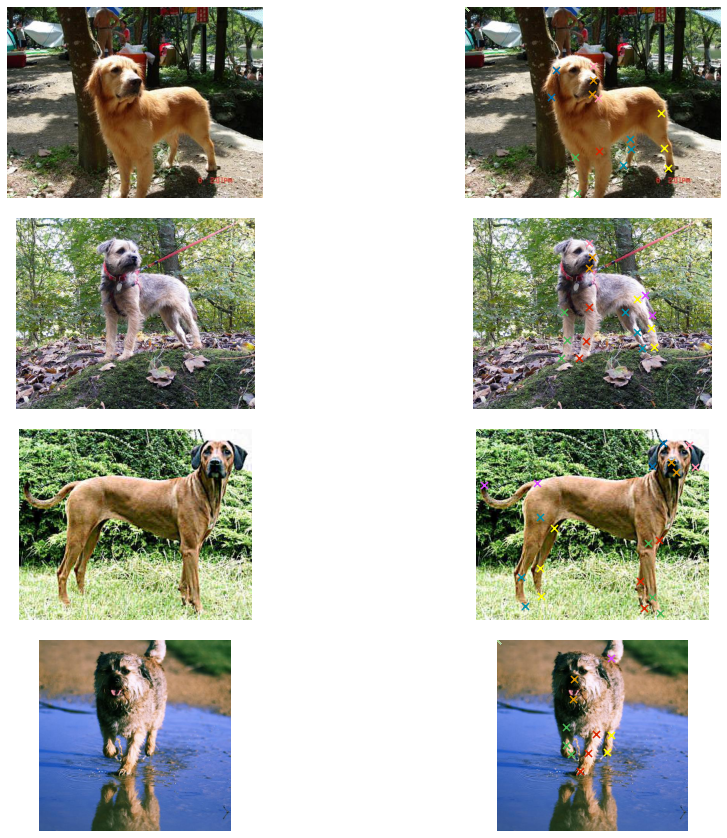

In [ ]:
# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb

def visualize_keypoints(images, keypoints):
  fig, axes = plt.subplots(nrows = len(images), ncols = 2, figsize=(16,12))
  [ax.axis('off') for ax in np.ravel(axes)]

  for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
    ax_orig.imshow(image)
    ax_all.imshow(image)

    # If the keypoints were formed by `imgaug` then the coordinates need
    # to be iterated differently.

    if isinstance(current_keypoint, KeypointsOnImage):
      for idx, kp in enumerate(current_keypoint.keypoints):
        ax_all.scatter(
            [kp.x], [kp.y], c = coloirs[idx], marker = 'x', s = 50, linewidths =5
        )
    else:
      current_keypoint = np.array(current_keypoint)
      # Since the last entry is the visibility flag, we discard it.
      current_keypoint = current_keypoint[:, :2]
      for idx, (x,y) in enumerate(current_keypoint):
        ax_all.scatter([x], [y], c = colours[idx], marker ='x', s = 50, linewidths=5)

  plt.tight_layout(pad=2.0)
  plt.show()



# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []


for sample in selected_samples:
  data = get_dog(sample)
  image = data['img_data']
  keypoint = data["joints"]

  images.append(image)
  keypoints.append(keypoint)


visualize_keypoints(images, keypoints)

In [ ]:
class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_dog(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 24 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

In [ ]:
train_aug = iaa.Sequential([
                            iaa.Resize(IMG_SIZE, interpolation = 'linear'),
                            iaa.Fliplr(0.3),
                            # `Sometimes()` applies a function randomly to the inputs with
                            # a given probability (0.3, in this case).
                            iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
])

test_aug = iaa.Sequential([ iaa.Resize(IMG_SIZE, interpolation='linear')])

In [ ]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)

In [ ]:
train_keys

['n02099601-golden_retriever/n02099601_2495.jpg',
 'n02092339-Weimaraner/n02092339_6543.jpg',
 'n02099601-golden_retriever/n02099601_345.jpg',
 'n02092339-Weimaraner/n02092339_6077.jpg',
 'n02093754-Border_terrier/n02093754_1845.jpg',
 'n02093754-Border_terrier/n02093754_3176.jpg',
 'n02093754-Border_terrier/n02093754_3113.jpg',
 'n02092339-Weimaraner/n02092339_6548.jpg',
 'n02087394-Rhodesian_ridgeback/n02087394_1352.jpg',
 'n02093754-Border_terrier/n02093754_6483.jpg',
 'n02099601-golden_retriever/n02099601_304.jpg',
 'n02092339-Weimaraner/n02092339_1013.jpg',
 'n02087394-Rhodesian_ridgeback/n02087394_10591.jpg',
 'n02087394-Rhodesian_ridgeback/n02087394_681.jpg',
 'n02099601-golden_retriever/n02099601_2796.jpg',
 'n02099601-golden_retriever/n02099601_176.jpg',
 'n02087394-Rhodesian_ridgeback/n02087394_831.jpg',
 'n02092339-Weimaraner/n02092339_748.jpg',
 'n02092339-Weimaraner/n02092339_6410.jpg',
 'n02093754-Border_terrier/n02093754_875.jpg',
 'n02099601-golden_retriever/n02099601_6

In [ ]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

Total batches in training set: 0
Total batches in validation set: 0


In [ ]:
sample_images, sample_keypoints = next(iter(train_dataset))
assert sample_keypoints.max() == 1.0
assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 24, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

StopIteration: ignored

In [ ]:
def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [ ]:
get_model().summary()


9412608/9406464 [==============================] - 0s 0us/step
Model: "keypoint_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1280)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 3, 3, 48)          93488     
____________________________________________________

In [ ]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/5


ValueError: ignored

In [ ]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 24, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 24, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)